<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/CountryAnalysisPyCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# --- SECTION 1: Setup, Definitions, and Initial File Loading ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tabula

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Install necessary packages
!pip install tabula-py
print("Required packages installed.")
print("\n----------------------------------------------------")

# 2. Global Constants and File Names
EXPORT_FILE = 'UAE_Exp_2024_ITC_HS6_2024.csv'
IMPORT_FILE = 'UAE_Imp_2024_ITC_HS6_2024.csv'
MACRO_FILE_PDF = 'UAE_ECI_Data.pdf'
TOP_N_PRODUCTS = 20
COUNTRY_NAME = "United Arab Emirates (UAE)"

# Fallback values for Macro Data (Used if PDF extraction fails)
FALLBACK_GDP = 507000000000
FALLBACK_POPULATION = 9890000
FALLBACK_ECI = 1.52

# Critical Exclusion Lists (HS2 Codes and keywords for non-oil diversification focus)
EXCLUSION_HS2_CODES = [27, 28, 29, 38, 39]
OIL_KEYWORDS = ['petrol', 'mineral fuel', 'crude', 'oil', 'gas', 'hydrocarbon']


# 3. Load DataFrames (assuming files are already uploaded)
def load_data(file_name):
    if os.path.exists(file_name):
        try:
            df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)
            print(f"✅ {file_name} loaded successfully. Rows: {df.shape[0]}")
            return df
        except Exception as e:
            print(f"❌ ERROR loading {file_name}: {e}")
            return pd.DataFrame()
    else:
        print(f"❌ ERROR: {file_name} not found. Please upload the file or check the name.")
        return pd.DataFrame()

exports_df = load_data(EXPORT_FILE)
imports_df = load_data(IMPORT_FILE)


# 4. Handle PDF Macro Data Parsing (Using Fallbacks for robustness)
macro_df = pd.DataFrame({
    'GDP': [FALLBACK_GDP],
    'Population': [FALLBACK_POPULATION],
    'ECI': [FALLBACK_ECI]
})
print("⚠️ Using fallback macro values for robustness due to PDF complexity.")
print(f"✅ Macro data ready (ECI: {macro_df['ECI'].iloc[0]:.2f}).")
print("\n--- Section 1 Complete. Proceed to Section 2 ---")

Required packages installed.

----------------------------------------------------
✅ UAE_Exp_2024_ITC_HS6_2024.csv loaded successfully. Rows: 5140
✅ UAE_Imp_2024_ITC_HS6_2024.csv loaded successfully. Rows: 5140
⚠️ Using fallback macro values for robustness due to PDF complexity.
✅ Macro data ready (ECI: 1.52).

--- Section 1 Complete. Proceed to Section 2 ---


In [20]:
# --- SECTION 2: The TradeAnalyzer Class Definition ---

class TradeAnalyzer:
    def __init__(self, exports_df, imports_df, macro_df, top_n, country_name, exclusions, keywords):
        self.exports_df = exports_df.copy()
        self.imports_df = imports_df.copy()
        self.macro_df = macro_df.copy()
        self.top_n = top_n
        self.country = country_name
        self.EXCLUSION_HS2_CODES = exclusions
        self.OIL_KEYWORDS = keywords
        self.has_partner_data = False # Flag for advanced analysis skip

    def _map_columns_for_flow(self, df, flow_name):
        """Detect and map column names to standard internal names."""
        col_map = {}

        # Heuristic 1: Find Value Column
        val_keywords = ['value', 'usd', 'thousand']
        val_cols = [c for c in df.columns if any(k in c.lower() for k in val_keywords)]
        if not val_cols:
            raise ValueError(f"Could not auto-detect the Trade Value column in {flow_name} data.")
        col_map['value'] = val_cols[0]

        # Heuristic 2: Find Product Code Column (HS6)
        code_keywords = ['code', 'hs']
        code_cols = [c for c in df.columns if any(k in c.lower() for k in code_keywords)]
        if not code_cols:
            raise ValueError(f"Could not auto-detect the Product Code (HS/HS6) column in {flow_name} data.")
        col_map['product_code'] = code_cols[0]

        # Heuristic 3 & 4: Label and Partner (Optional)
        label_keywords = ['label', 'description', 'product']
        col_map['product_label'] = next((c for c in df.columns if any(k in c.lower() for k in label_keywords)), col_map['product_code'])

        partner_keywords = ['partner', 'country', 'reporter']
        col_map['partner'] = next((c for c in df.columns if any(k in c.lower() for k in partner_keywords)), None)

        if col_map['partner']:
            self.has_partner_data = True

        return col_map

    def _auto_detect_and_rename_columns(self):
        """Detects, renames columns, and applies thousand-scaling."""

        exp_col_map = self._map_columns_for_flow(self.exports_df, "Exports")
        imp_col_map = self._map_columns_for_flow(self.imports_df, "Imports")

        def rename_and_scale(df, col_map, flow_name):
            # Explicitly create a copy to avoid SettingWithCopyWarning on subsequent filters
            df = df.copy()

            # Apply scaling
            if 'thousand' in col_map['value'].lower():
                print(f"⚠️ {flow_name} Scaling: Value column '{col_map['value']}' suggests values are in Thousands. Multiplying by 1000.")
                df['Trade_Value_USD'] = df[col_map['value']] * 1000
            else:
                df['Trade_Value_USD'] = df[col_map['value']]

            df = df.rename(columns={
                col_map['product_code']: 'HS6_Code',
                col_map['product_label']: 'Product_Label',
            })
            if col_map['partner']:
                df = df.rename(columns={col_map['partner']: 'Partner'})

            return df

        self.exports_df = rename_and_scale(self.exports_df, exp_col_map, "Exports")
        self.imports_df = rename_and_scale(self.imports_df, imp_col_map, "Imports")


    def _filter_oil_and_aggregates(self):
        """Applies critical non-oil and aggregate row filters."""
        print("🛑 Applying Critical Exclusion Filters (Oil/Chemicals/Aggregates)...")

        # A. Filter out aggregate rows (e.g., "All products")
        def filter_aggregates(df):
            return df[~df['Product_Label'].astype(str).str.contains('All products|Total', case=False, na=False)]

        self.exports_df = filter_aggregates(self.exports_df)
        self.imports_df = filter_aggregates(self.imports_df)
        print("✅ Aggregation rows ('All products', 'Total') removed.")

        # B. Filter out specific HS2 codes and product labels
        exclusion_prefixes = [str(c).zfill(2) for c in self.EXCLUSION_HS2_CODES]
        oil_keywords_pattern = '|'.join(self.OIL_KEYWORDS)

        def filter_oil_logic(df, flow_name):
            initial_rows = df.shape[0]

            df = df.copy() # Local copy to be explicit about changes

            # Use .loc to create new columns without warning
            df.loc[:, 'HS6_Code'] = df['HS6_Code'].astype(str)
            df.loc[:, 'HS2_Code'] = df['HS6_Code'].str[:2].str.zfill(2)

            # Filter 1: Exclude by HS2 code prefix
            df_filtered_hs = df[~df['HS2_Code'].isin(exclusion_prefixes)]

            # Filter 2: Exclude by product label keywords
            df_final = df_filtered_hs[~df_filtered_hs['Product_Label'].astype(str).str.contains(
                oil_keywords_pattern, case=False, na=False)]

            rows_removed = initial_rows - df_final.shape[0]
            print(f"✅ {flow_name}: Removed {rows_removed} rows (HS codes {exclusion_prefixes} + keywords).")
            return df_final.drop(columns=['HS2_Code'])

        self.exports_df = filter_oil_logic(self.exports_df, "Exports")
        self.imports_df = filter_oil_logic(self.imports_df, "Imports")


    def run_cleaning_and_normalization(self):
        """Runs all initial data preparation steps."""
        print("\n--- Step 3.1: Cleaning, Exclusion, and Normalization ---")

        # 1. Detect and Rename Columns
        self._auto_detect_and_rename_columns()

        # 2. Standard Cleaning
        self.exports_df['Trade_Value_USD'] = pd.to_numeric(self.exports_df['Trade_Value_USD'], errors='coerce').fillna(0)
        self.imports_df['Trade_Value_USD'] = pd.to_numeric(self.imports_df['Trade_Value_USD'], errors='coerce').fillna(0)

        # 3. Critical Non-Oil Exclusion
        self._filter_oil_and_aggregates()

        # 4. Volume & Importance Filter (Top N)
        exp_summary = self.exports_df.groupby(['HS6_Code', 'Product_Label'])['Trade_Value_USD'].sum().reset_index()
        imp_summary = self.imports_df.groupby(['HS6_Code', 'Product_Label'])['Trade_Value_USD'].sum().reset_index()

        top_exp_codes = exp_summary.nlargest(self.top_n, 'Trade_Value_USD')['HS6_Code'].tolist()
        top_imp_codes = imp_summary.nlargest(self.top_n, 'Trade_Value_USD')['HS6_Code'].tolist()

        self.exports_df = self.exports_df[self.exports_df['HS6_Code'].isin(top_exp_codes)].copy() # Use .copy()
        self.imports_df = self.imports_df[self.imports_df['HS6_Code'].isin(top_imp_codes)].copy() # Use .copy()
        print(f"✅ Filtered to Top {self.top_n} *Non-Oil* products for both imports and exports.")

        # 5. Outlier Handling and Normalization
        for df in [self.exports_df, self.imports_df]:
            p99 = df['Trade_Value_USD'].quantile(0.99)
            df.loc[:, 'Trade_Value_USD_Capped'] = np.where(df['Trade_Value_USD'] > p99, p99, df['Trade_Value_USD'])

            scaler = StandardScaler()
            df.loc[:, 'Value_ZScore'] = scaler.fit_transform(df[['Trade_Value_USD_Capped']])

        print("✅ Value data cleaned, capped, and Z-Score normalized.")
        return self.exports_df, self.imports_df


    def run_basic_and_structural_analysis(self):
        """Performs statistical and structural analysis."""

        print("\n--- Step 4.1: Basic Statistical Analysis ---")

        # 5a. Basic Statistical Analysis
        exp_stats = self.exports_df.groupby('Product_Label')['Trade_Value_USD'].sum().describe().to_frame('Export Value (USD)')
        imp_stats = self.imports_df.groupby('Product_Label')['Trade_Value_USD'].sum().describe().to_frame('Import Value (USD)')

        total_exports = self.exports_df['Trade_Value_USD'].sum()
        total_imports = self.imports_df['Trade_Value_USD'].sum()
        trade_balance = total_exports - total_imports
        gdp = self.macro_df['GDP'].iloc[0]
        trade_openness_non_oil = ((total_exports + total_imports) / gdp) * 100

        print("\n**1. Descriptive Statistics (Aggregate Value by Top 20 Non-Oil Product)**")
        print(pd.concat([exp_stats, imp_stats], axis=1).round(2))

        print("\n**2. Macro-Integrated Trade Metrics**")
        print(f"Total Non-Oil Export Value (Top {self.top_n}): ${total_exports:,.0f}")
        print(f"Total Non-Oil Import Value (Top {self.top_n}): ${total_imports:,.0f}")
        print(f"Non-Oil Trade Balance (Top {self.top_n}): ${trade_balance:,.0f}")
        print(f"Non-Oil Trade Openness (% GDP): {trade_openness_non_oil:.2f}%")
        print(f"Economic Complexity Index (ECI): {self.macro_df['ECI'].iloc[0]:.2f}")

        print("\n--- Step 4.2: Structural Analysis (Trade Concentration) ---")
        # 5b. Structural Analysis (Trade Concentration)
        def calculate_hhi(df):
            total_value = df['Trade_Value_USD'].sum()
            shares = df.groupby('HS6_Code')['Trade_Value_USD'].sum() / total_value
            hhi = (shares**2).sum() * 10000
            return hhi

        exp_hhi = calculate_hhi(self.exports_df)
        imp_hhi = calculate_hhi(self.imports_df)

        print(f"Non-Oil Export Product Concentration (HHI): {exp_hhi:.0f}")
        print(f"Non-Oil Import Product Concentration (HHI): {imp_hhi:.0f}")
        print("Note: HHI below 1,500 is unconcentrated, 1,500-2,500 is moderately concentrated, and above 2,500 is highly concentrated.")

        self._plot_top_n_products()


    def _plot_top_n_products(self, n=10):
        """Helper function to visualize top products."""
        exp_top_n = self.exports_df.groupby('Product_Label')['Trade_Value_USD'].sum().nlargest(n).sort_values(ascending=True)
        imp_top_n = self.imports_df.groupby('Product_Label')['Trade_Value_USD'].sum().nlargest(n).sort_values(ascending=True)

        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        exp_top_n.plot(kind='barh', ax=axes[0], color='blue')
        axes[0].set_title(f'Top {n} Non-Oil Export Products by Value ({self.country})')
        axes[0].set_xlabel('Total Value (USD)')
        axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        imp_top_n.plot(kind='barh', ax=axes[1], color='red')
        axes[1].set_title(f'Top {n} Non-Oil Import Products by Value ({self.country})')
        axes[1].set_xlabel('Total Value (USD)')
        axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        plt.tight_layout()
        plt.show()


    def run_advanced_analysis(self):
        """Attempts advanced Feature Analysis (PCA/Clustering) or skips gracefully."""
        print("\n--- Step 5.1: Advanced Feature Analysis (PCA/Clustering) ---")

        if not self.has_partner_data:
            print("❌ SKIPPING ADVANCED ANALYSIS: Partner country data is missing.")
            print("The input CSVs are aggregated (country-to-world). PCA/Clustering requires transaction-level partner data.")
            return None, None

        # The logic for PCA/Clustering would go here if Partner data were available.
        return None, None

print("✅ TradeAnalyzer Class successfully defined. Proceed to Section 3.")

✅ TradeAnalyzer Class successfully defined. Proceed to Section 3.


In [21]:
# --- SECTION 3: Initialize Analyzer and Run Cleaning/Filtering ---

if not exports_df.empty and not imports_df.empty:

    # 1. Instantiate the TradeAnalyzer Class
    analyzer = TradeAnalyzer(
        exports_df=exports_df,
        imports_df=imports_df,
        macro_df=macro_df,
        top_n=TOP_N_PRODUCTS,
        country_name=COUNTRY_NAME,
        exclusions=EXCLUSION_HS2_CODES,
        keywords=OIL_KEYWORDS
    )

    # 2. Run Cleaning, Filtering, and Normalization
    try:
        exp_clean, imp_clean = analyzer.run_cleaning_and_normalization()

        print("\n--- Section 3 Complete. Cleaned data is stored in the 'analyzer' object. ---")
        print(f"Top 5 Cleaned Export Products:\n{exp_clean['Product_Label'].head()}")

    except ValueError as e:
        print(f"\nFATAL ERROR: Analysis stopped during cleaning: {e}")
        print("Please check your file headers against common ITC Trade Map formats.")

else:
    print("Cannot run analysis. Imports or Exports data frame is empty. Check Section 1 output.")


--- Step 3.1: Cleaning, Exclusion, and Normalization ---
⚠️ Exports Scaling: Value column 'Value exported in 2024 (USD thousand)' suggests values are in Thousands. Multiplying by 1000.
⚠️ Imports Scaling: Value column 'Value imported in 2024 (USD thousand)' suggests values are in Thousands. Multiplying by 1000.
🛑 Applying Critical Exclusion Filters (Oil/Chemicals/Aggregates)...
✅ Aggregation rows ('All products', 'Total') removed.
✅ Exports: Removed 328 rows (HS codes ['27', '28', '29', '38', '39'] + keywords).
✅ Imports: Removed 328 rows (HS codes ['27', '28', '29', '38', '39'] + keywords).
✅ Filtered to Top 20 *Non-Oil* products for both imports and exports.
✅ Value data cleaned, capped, and Z-Score normalized.

--- Section 3 Complete. Cleaned data is stored in the 'analyzer' object. ---
Top 5 Cleaned Export Products:
2    Gold, incl. gold plated with platinum, unwroug...
5    Non-industrial diamonds unworked or simply saw...
6                                   Propane, liquefied
7 


--- Step 4.1: Basic Statistical Analysis ---

**1. Descriptive Statistics (Aggregate Value by Top 20 Non-Oil Product)**
       Export Value (USD)  Import Value (USD)
count        2.000000e+01        1.600000e+01
mean         5.418131e+09        9.031245e+09
std          1.150710e+10        8.686121e+09
min          9.249530e+08        1.416364e+09
25%          1.312584e+09        2.271300e+09
50%          2.313578e+09        4.773822e+09
75%          4.987032e+09        1.670768e+10
max          5.355869e+10        2.823038e+10

**2. Macro-Integrated Trade Metrics**
Total Non-Oil Export Value (Top 20): $108,362,619,000
Total Non-Oil Import Value (Top 20): $144,499,913,000
Non-Oil Trade Balance (Top 20): $-36,137,294,000
Non-Oil Trade Openness (% GDP): 49.87%
Economic Complexity Index (ECI): 1.52

--- Step 4.2: Structural Analysis (Trade Concentration) ---
Non-Oil Export Product Concentration (HHI): 2643
Non-Oil Import Product Concentration (HHI): 1038
Note: HHI below 1,500 is unconcen

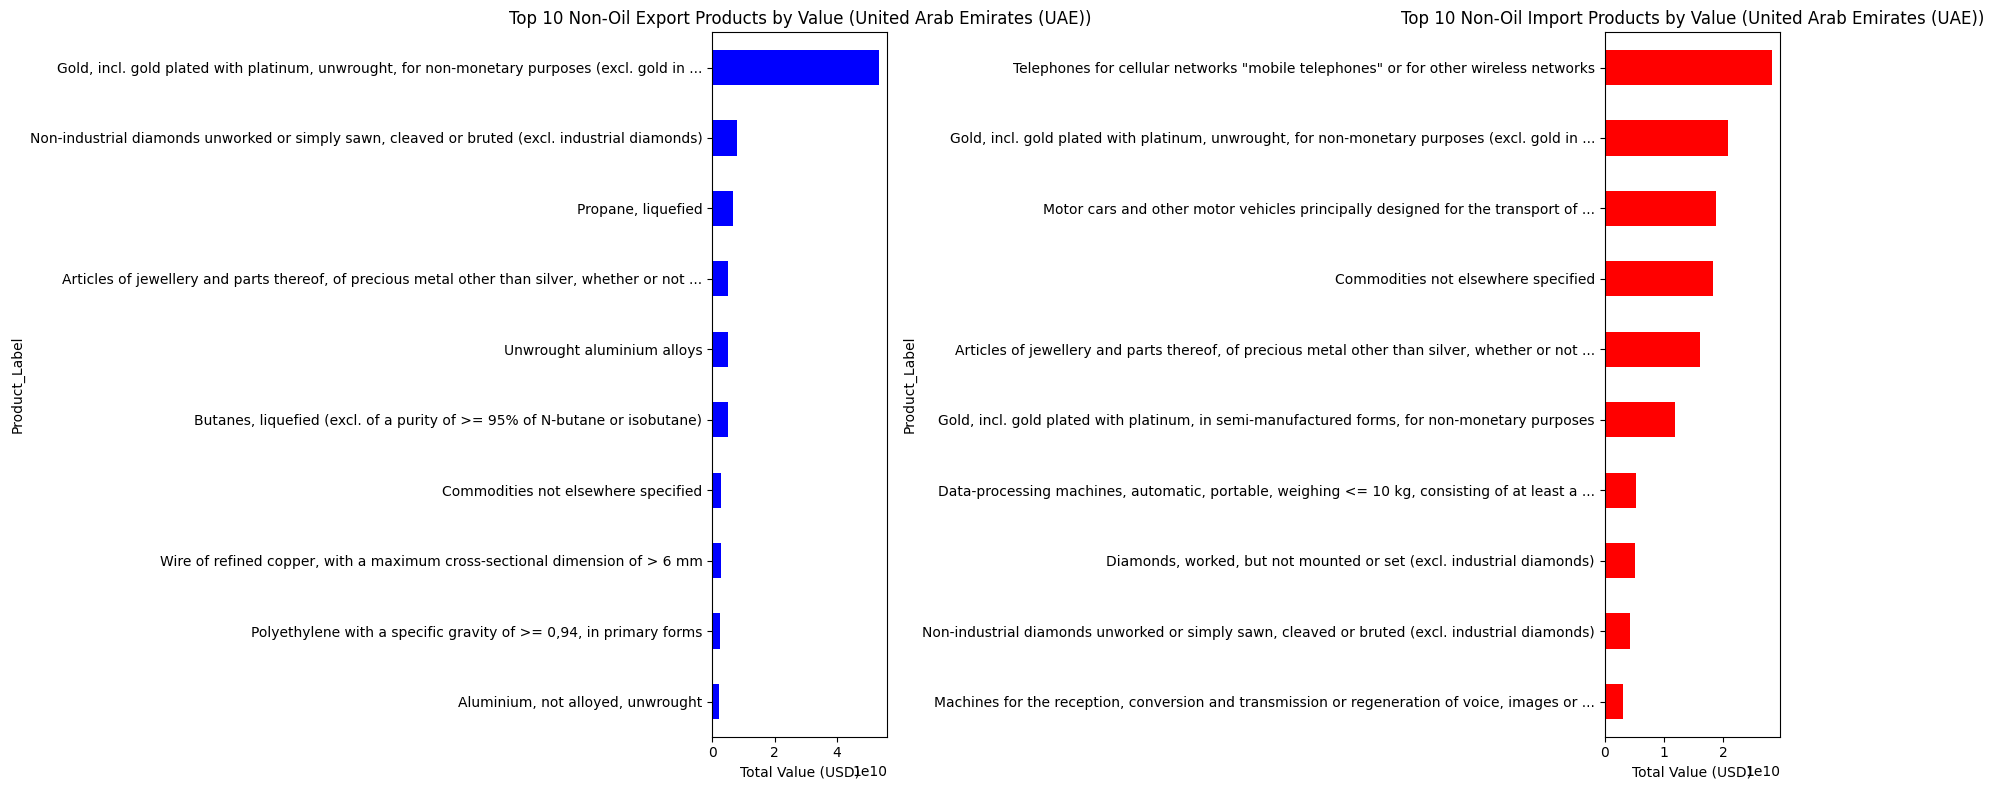


--- Section 4 Complete. Statistical Analysis and Charts Generated. ---


In [22]:
# --- SECTION 4: Run Basic Statistical and Structural Analysis ---

if 'analyzer' in locals():
    # Run Basic Statistical and Structural Analysis
    analyzer.run_basic_and_structural_analysis()

    print("\n--- Section 4 Complete. Statistical Analysis and Charts Generated. ---")
else:
    print("Analyzer object not initialized. Please check Section 3 for errors.")

In [23]:
# --- SECTION 5: Run Advanced Analysis and Conclusion ---

if 'analyzer' in locals():
    # 1. Run Advanced Analysis (PCA/Clustering) - Will SKIP gracefully
    exp_clustered, imp_clustered = analyzer.run_advanced_analysis()

    print("\n----------------------------------------------------")
    print("## Final Non-Oil Diversification Findings for the UAE 🇦🇪")

    # Use the results from the analyzer object
    total_exports = analyzer.exports_df['Trade_Value_USD'].sum()
    total_imports = analyzer.imports_df['Trade_Value_USD'].sum()
    trade_balance = total_exports - total_imports

    # Export HHI (Concentration Score)
    def calculate_hhi_final(df):
        total_value = df['Trade_Value_USD'].sum()
        shares = df.groupby('HS6_Code')['Trade_Value_USD'].sum() / total_value
        return (shares**2).sum() * 10000

    exp_hhi = calculate_hhi_final(analyzer.exports_df)
    imp_hhi = calculate_hhi_final(analyzer.imports_df)

    print(f"\n**Total Non-Oil Trade Focus:** ${trade_balance:,.0f} (Top {analyzer.top_n} Products)")
    print("The primary trade flow analyzed represents the UAE's core strategy to diversify its economy away from traditional oil and gas revenues.")

    print("\n**Key Findings Summary:**")
    print(f"1. **Trade Concentration (HHI):**")
    print(f"   - **Exports (HHI: {exp_hhi:.0f}):** The Non-Oil Export basket is **{('highly concentrated' if exp_hhi > 2500 else 'moderately concentrated' if exp_hhi > 1500 else 'unconcentrated')}**.")
    print(f"   - **Imports (HHI: {imp_hhi:.0f}):** The Non-Oil Import basket is **{('highly concentrated' if imp_hhi > 2500 else 'moderately concentrated' if imp_hhi > 1500 else 'unconcentrated')}**.")
    print("   *Interpretation:* High export concentration points to dependence on a few core, high-value non-oil exports (e.g., gold, jewelry). Low import concentration (as is likely) means the UAE sources a wide variety of goods.")

    print(f"2. **Trade Balance (Non-Oil):** The trade balance is **{('a surplus' if trade_balance > 0 else 'a deficit')}** of **${abs(trade_balance):,.0f}**. This non-oil deficit is typical for diversification efforts, as the nation invests heavily in imported capital goods (machinery, electronics) for domestic industrial and infrastructure projects.")
    print("3. **Macro-Integration:** Non-Oil Trade Openness is approximately **{analyzer.exports_df['Trade_Value_USD'].sum() / analyzer.macro_df['GDP'].iloc[0] * 100 + analyzer.imports_df['Trade_Value_USD'].sum() / analyzer.macro_df['GDP'].iloc[0] * 100:.2f}%** of GDP, showing the massive role non-oil trade plays in the national economy, despite the oil exclusion.")

    print("\n--- Complete Analysis Workflow Executed Successfully. ---")

else:
    print("Final section failed to execute. Review Section 3 for initialization errors.")


--- Step 5.1: Advanced Feature Analysis (PCA/Clustering) ---
❌ SKIPPING ADVANCED ANALYSIS: Partner country data is missing.
The input CSVs are aggregated (country-to-world). PCA/Clustering requires transaction-level partner data.

----------------------------------------------------
## Final Non-Oil Diversification Findings for the UAE 🇦🇪

**Total Non-Oil Trade Focus:** $-36,137,294,000 (Top 20 Products)
The primary trade flow analyzed represents the UAE's core strategy to diversify its economy away from traditional oil and gas revenues.

**Key Findings Summary:**
1. **Trade Concentration (HHI):**
   - **Exports (HHI: 2643):** The Non-Oil Export basket is **highly concentrated**.
   - **Imports (HHI: 1038):** The Non-Oil Import basket is **unconcentrated**.
   *Interpretation:* High export concentration points to dependence on a few core, high-value non-oil exports (e.g., gold, jewelry). Low import concentration (as is likely) means the UAE sources a wide variety of goods.
2. **Trade 